Données prêtes : (48378, 17)


/tmp/ipykernel_23742/1248263565.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='type_hote', y='availability_365', data=df, order=order, palette=pal, ax=ax[1])


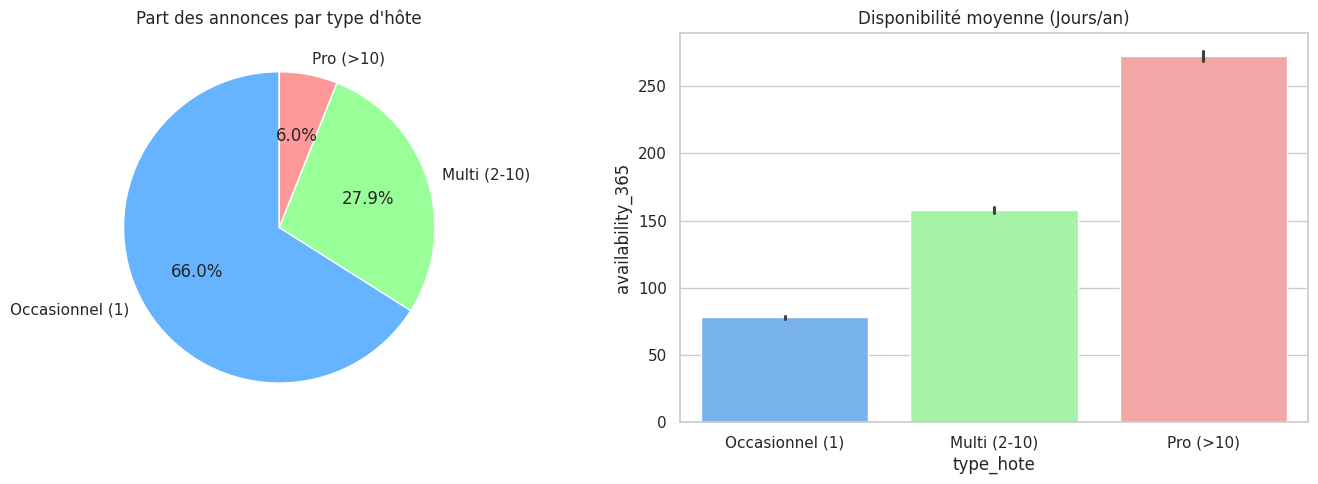

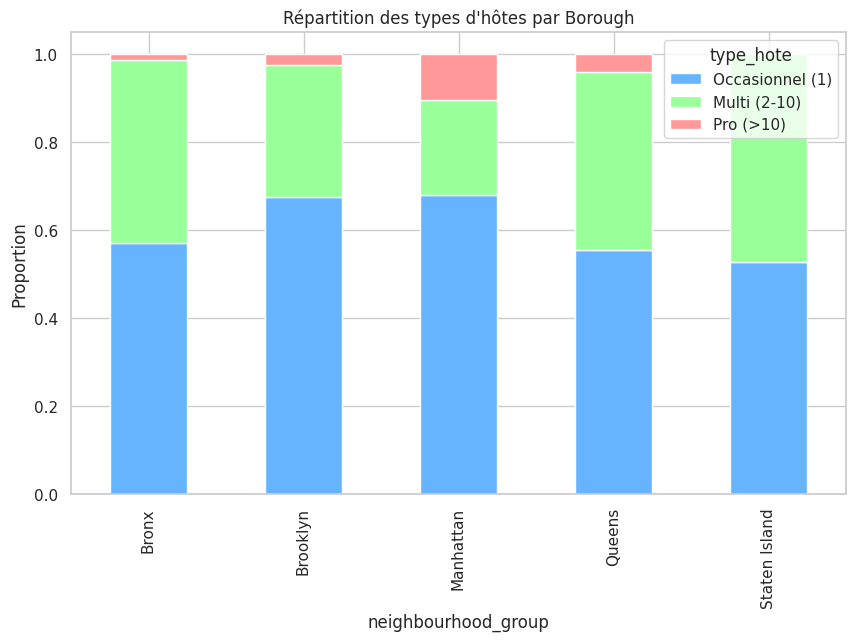

/tmp/ipykernel_23742/1248263565.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='type_hote', y='price', data=df, order=order, palette=pal, ax=ax[1])


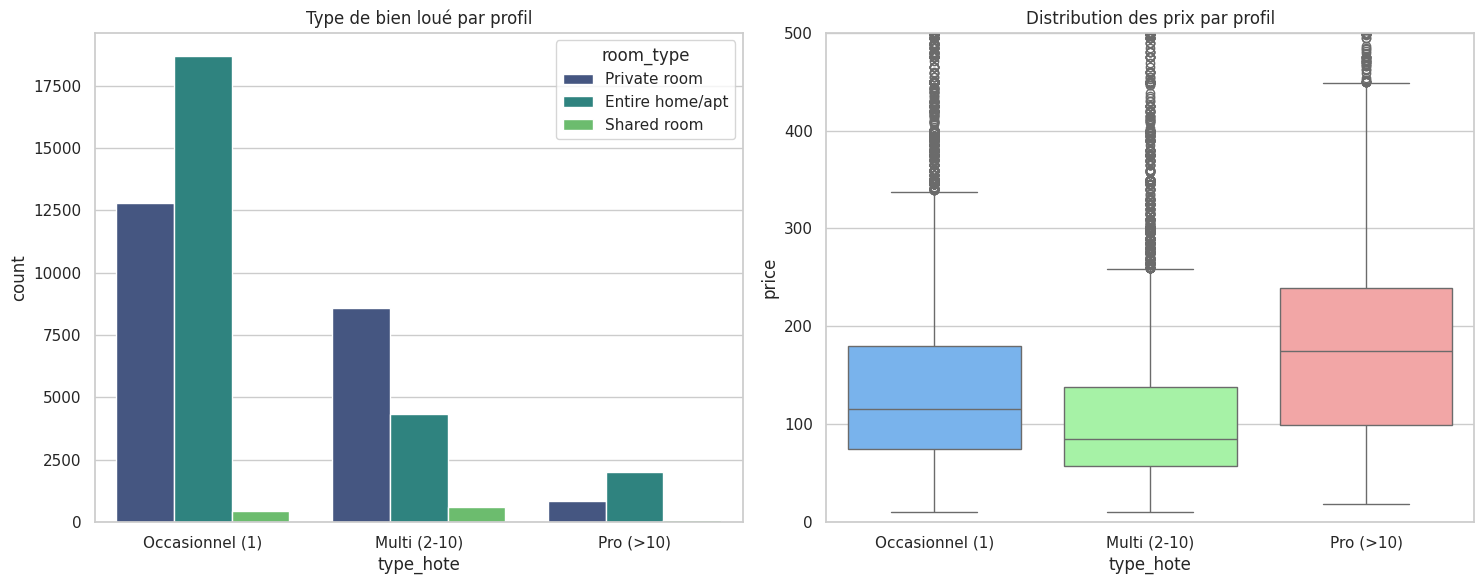

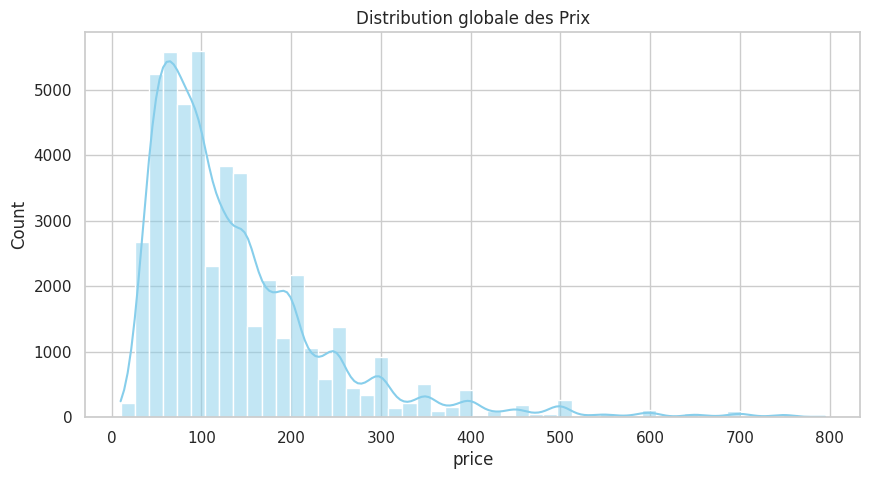

/tmp/ipykernel_23742/1248263565.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='neighbourhood_group', y='price', data=df, order=order_prix, palette="coolwarm")


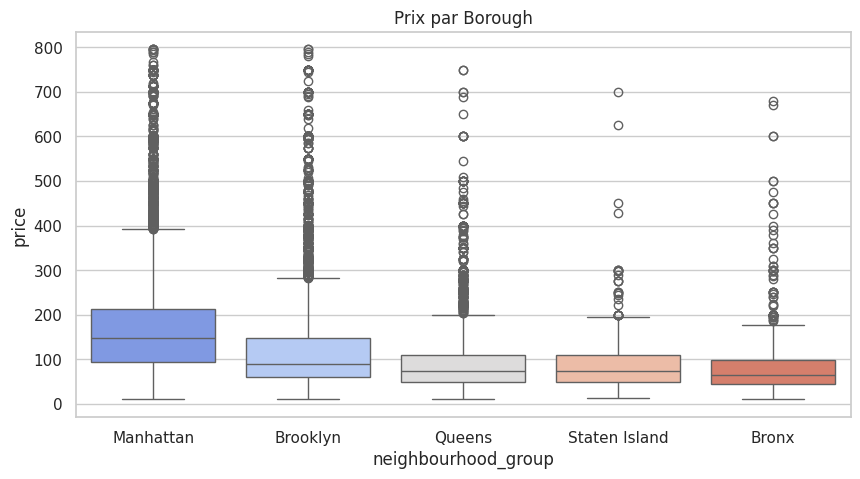

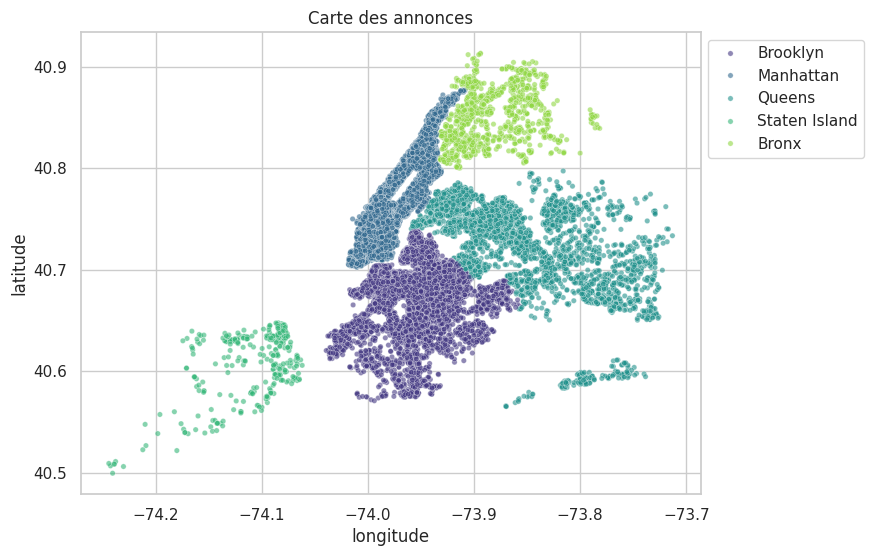

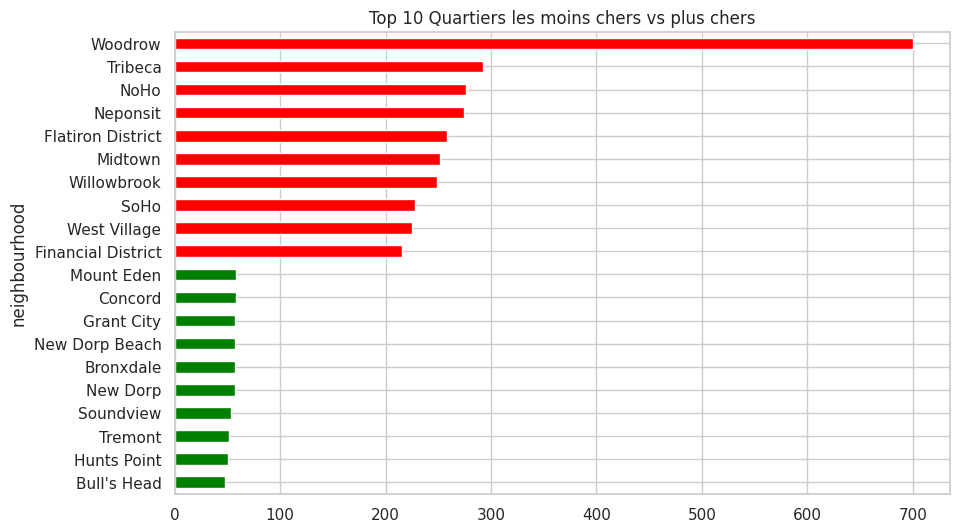

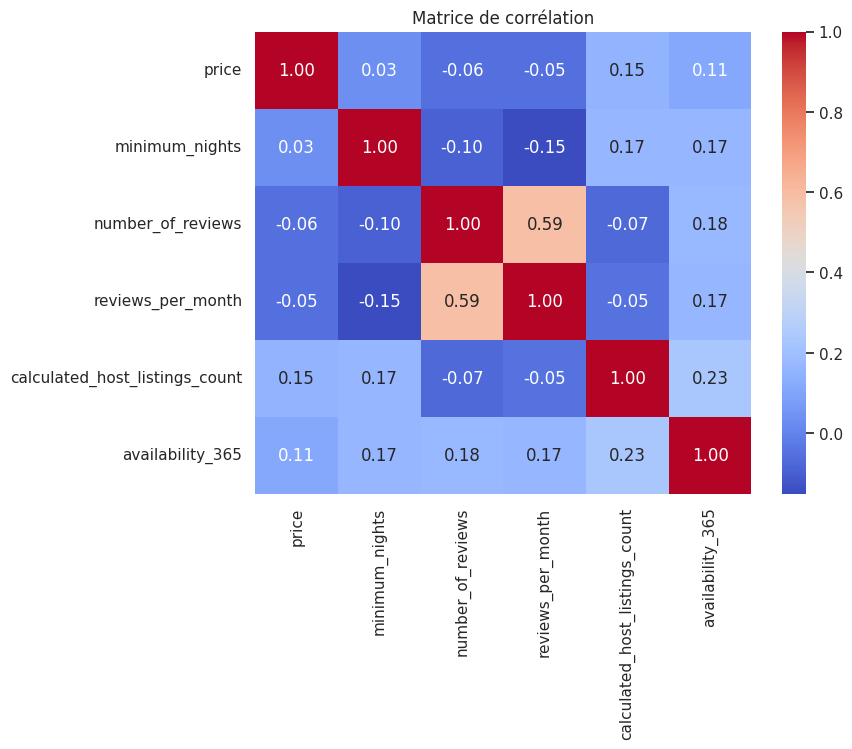

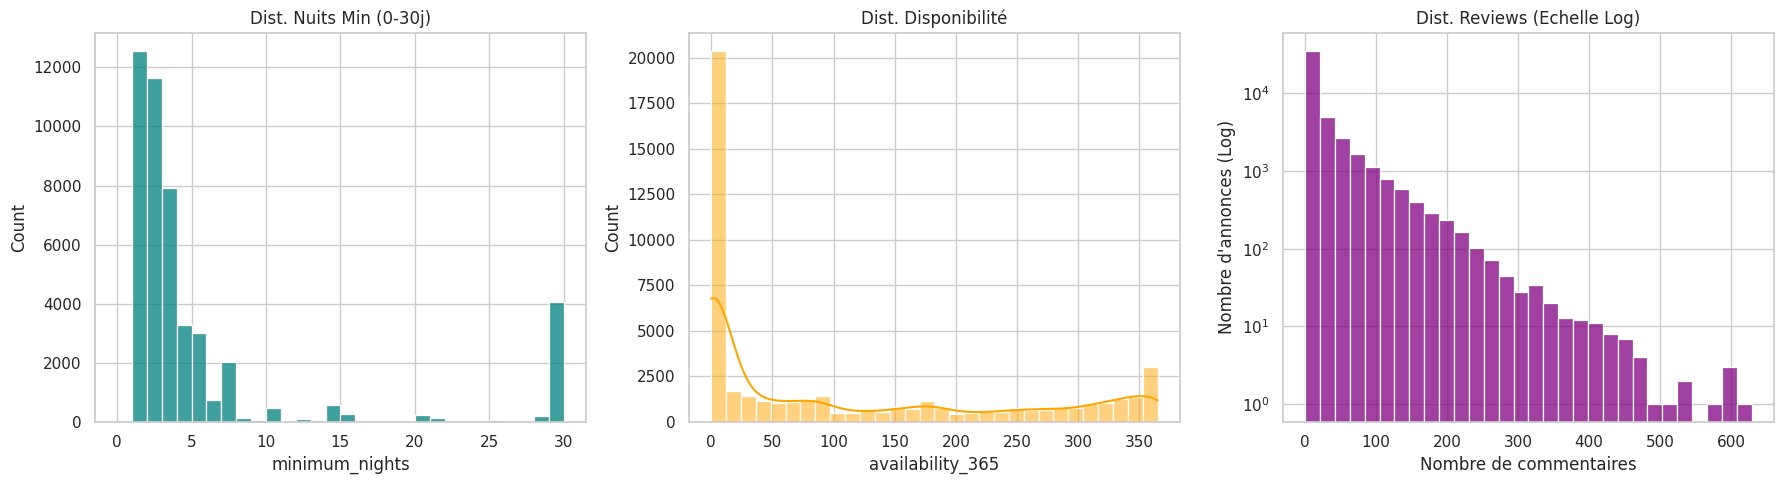

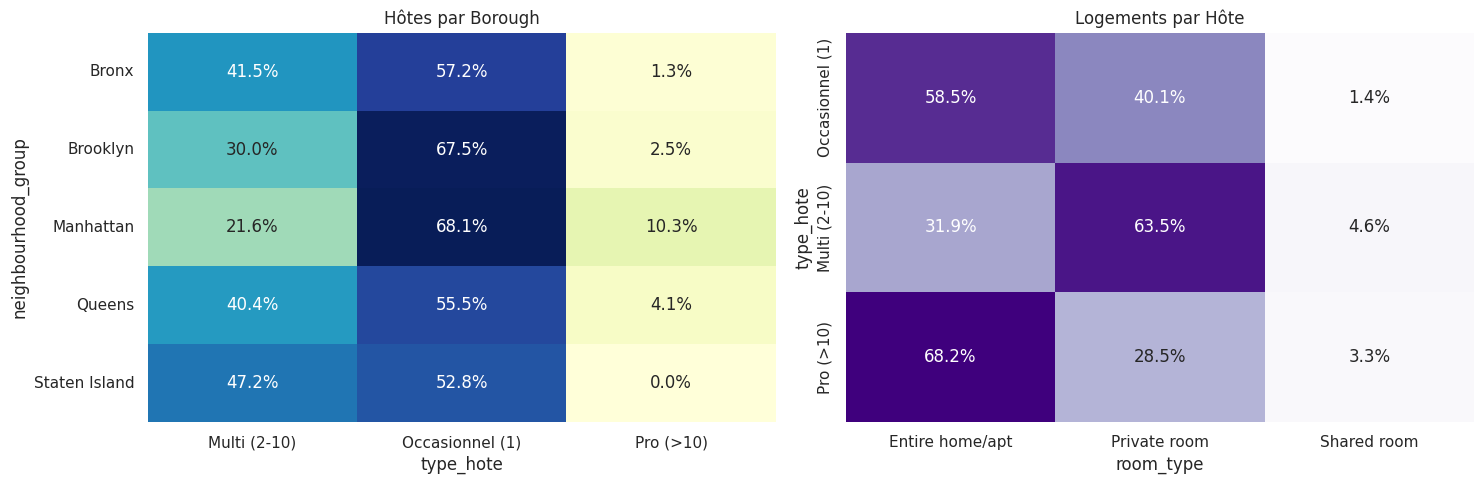


--- RÉSUMÉ PART DE MARCHÉ ---
                      price  availability_365  Count  Part (%)
type_hote                                                     
Multi (2-10)     114.238067        157.852882  13513     27.93
Occasionnel (1)  142.312504         77.854799  31942     66.03
Pro (>10)        189.620595        272.537804   2923      6.04

--- TESTS KRUSKAL-WALLIS (H0: Pas de différence entre hôtes) ---
price               : p-value = 0.00e+00 (Significatif)
availability_365    : p-value = 0.00e+00 (Significatif)
number_of_reviews   : p-value = 0.00e+00 (Significatif)
minimum_nights      : p-value = 0.00e+00 (Significatif)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Configuration globale
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# 1. CHARGEMENT ET NETTOYAGE
df = pd.read_csv('Airbnb_NYC_2019.csv')
df.drop_duplicates(inplace=True)
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)
df.dropna(subset=['price', 'neighbourhood_group', 'latitude', 'longitude'], inplace=True)
df = df[(df['price'] > 0) & (df['price'] < df['price'].quantile(0.99))] # Filtre prix
df = df[df['minimum_nights'] <= 365] # Filtre nuits
df['last_review'] = pd.to_datetime(df['last_review'])

# 2. SEGMENTATION (Feature Engineering)
def cat_hote(c): return 'Occasionnel (1)' if c == 1 else 'Multi (2-10)' if c <= 10 else 'Pro (>10)'
df['type_hote'] = df['calculated_host_listings_count'].apply(cat_hote)
order = ['Occasionnel (1)', 'Multi (2-10)', 'Pro (>10)']
pal = {'Occasionnel (1)': '#66b3ff', 'Multi (2-10)': '#99ff99', 'Pro (>10)': '#ff9999'}

print(f"Données prêtes : {df.shape}")

# =========================================================
# BLOC 1 : STRUCTURE DU MARCHÉ (Hôtes & Dispo)
# =========================================================
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Pie Chart : Part de marché
counts = df['type_hote'].value_counts().reindex(order)
ax[0].pie(counts, labels=counts.index, autopct='%1.1f%%', colors=[pal[k] for k in order], startangle=90)
ax[0].set_title("Part des annonces par type d'hôte")

# Barplot : Disponibilité
sns.barplot(x='type_hote', y='availability_365', data=df, order=order, palette=pal, ax=ax[1])
ax[1].set_title("Disponibilité moyenne (Jours/an)")
plt.tight_layout()
plt.show()

# =========================================================
# BLOC 2 : GÉOGRAPHIE & OFFRE
# =========================================================
# Stacked Bar : Hôtes par Quartier
ct = pd.crosstab(df['neighbourhood_group'], df['type_hote'])
ct.div(ct.sum(1), axis=0)[order].plot(kind='bar', stacked=True, color=[pal[k] for k in order], figsize=(10, 6))
plt.title("Répartition des types d'hôtes par Borough")
plt.ylabel("Proportion")
plt.show()

# Subplots : Type de chambre & Prix par hôte
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.countplot(x='type_hote', hue='room_type', data=df, order=order, palette='viridis', ax=ax[0])
ax[0].set_title("Type de bien loué par profil")
sns.boxplot(x='type_hote', y='price', data=df, order=order, palette=pal, ax=ax[1])
ax[1].set_title("Distribution des prix par profil")
ax[1].set_ylim(0, 500)
plt.tight_layout()
plt.show()

# =========================================================
# BLOC 3 : ANALYSE GÉNÉRALE (Prix, Map, Quartiers, Correl)
# =========================================================
# Distribution Prix
plt.figure(figsize=(10, 5))
sns.histplot(df['price'], kde=True, bins=50, color='skyblue')
plt.title('Distribution globale des Prix')
plt.show()

# Prix par Borough
order_prix = df.groupby("neighbourhood_group")["price"].median().sort_values(ascending=False).index
plt.figure(figsize=(10, 5))
sns.boxplot(x='neighbourhood_group', y='price', data=df, order=order_prix, palette="coolwarm")
plt.title('Prix par Borough')
plt.show()

# Carte
plt.figure(figsize=(8, 6))
sns.scatterplot(x='longitude', y='latitude', hue='neighbourhood_group', data=df, alpha=0.6, s=15, palette='viridis')
plt.title('Carte des annonces')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

# Top/Flop Quartiers
top_bottom = pd.concat([df.groupby('neighbourhood')['price'].mean().sort_values().head(10), 
                        df.groupby('neighbourhood')['price'].mean().sort_values().tail(10)])
top_bottom.plot(kind='barh', color=['green']*10 + ['red']*10, figsize=(10, 6))
plt.title('Top 10 Quartiers les moins chers vs plus chers')
plt.show()

# Corrélation
plt.figure(figsize=(8, 6))
cols = ['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
sns.heatmap(df[cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice de corrélation')
plt.show()

# =========================================================
# BLOC 4 : DÉTAILS VOLUMES & DISTRIBUTIONS 
# =========================================================

# On s'assure que la colonne est bien numérique (au cas où)
df['number_of_reviews'] = pd.to_numeric(df['number_of_reviews'], errors='coerce').fillna(0)

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# 1. Minimum Nights
sns.histplot(df['minimum_nights'], bins=30, binrange=(0, 30), ax=ax[0], color='teal', kde=False)
ax[0].set_title("Dist. Nuits Min (0-30j)")

# 2. Disponibilité
sns.histplot(df['availability_365'], bins=30, ax=ax[1], color='orange', kde=True)
ax[1].set_title("Dist. Disponibilité")

# 3. Reviews 
# On enlève 'log_scale' de la fonction et on l'applique sur l'axe après
sns.histplot(df['number_of_reviews'], bins=30, ax=ax[2], color='purple')
ax[2].set_yscale('log') # On force l'échelle log sur l'axe Y via Matplotlib directement
ax[2].set_title("Dist. Reviews (Echelle Log)")
ax[2].set_xlabel("Nombre de commentaires")
ax[2].set_ylabel("Nombre d'annonces (Log)")

plt.tight_layout()
plt.show()

# =========================================================
# BLOC 5 : CROISEMENTS & STATISTIQUES
# =========================================================
# Heatmaps croisées
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(pd.crosstab(df['neighbourhood_group'], df['type_hote'], normalize='index'), annot=True, fmt=".1%", cmap="YlGnBu", ax=ax[0], cbar=False)
sns.heatmap(pd.crosstab(df['type_hote'], df['room_type'], normalize='index').reindex(order), annot=True, fmt=".1%", cmap="Purples", ax=ax[1], cbar=False)
ax[0].set_title("Hôtes par Borough"); ax[1].set_title("Logements par Hôte")
plt.tight_layout()
plt.show()

# Résumé & Stats
print("\n--- RÉSUMÉ PART DE MARCHÉ ---")
summary = df.groupby('type_hote').agg({'price':'mean', 'availability_365':'mean', 'id':'count'}).rename(columns={'id':'Count'})
summary['Part (%)'] = (summary['Count'] / len(df) * 100).round(2)
print(summary)

print("\n--- TESTS KRUSKAL-WALLIS (H0: Pas de différence entre hôtes) ---")
groups = [df[df['type_hote'] == h] for h in order]
for var in ['price', 'availability_365', 'number_of_reviews', 'minimum_nights']:
    stat, p = stats.kruskal(groups[0][var], groups[1][var], groups[2][var])
    print(f"{var.ljust(20)}: p-value = {p:.2e} {'(Significatif)' if p < 0.05 else ''}")